In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from typing import Tuple
from tqdm import tqdm

# TD Learning

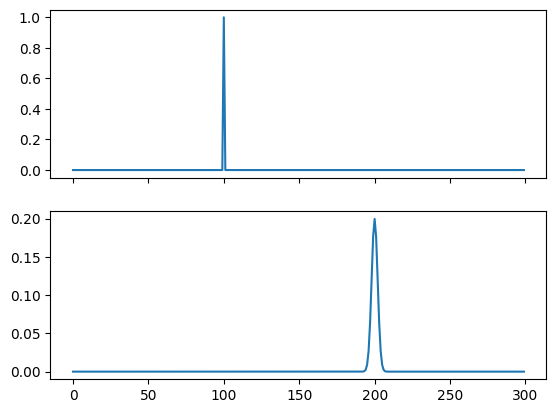

In [66]:
def add_stimulus(series: np.ndarray, t: int = 100, std: float = 0):
    # add a gaussian stimulus at time t and with distribution std
    if std != 0:
        raise NotImplementedError("Currently assuming only point mass stimulus")
    
    series[t] += 1
    return series


def add_reward(series: np.ndarray, t: int = 200, std: float = 2):
    x = np.arange(len(series))
    y = 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - t)**2 / std**2)
    return series + y


length = 300
stimulus = np.zeros(length)
stimulus = add_stimulus(stimulus)
reward = np.zeros(length)
reward = add_reward(reward)

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(stimulus)
ax[1].plot(reward)

100%|██████████| 200/200 [00:00<00:00, 449.77it/s]


Text(0, 0.5, 'u')

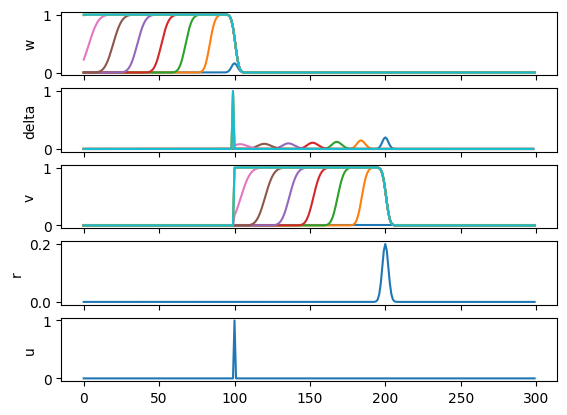

In [97]:
epsilon = 0.8
n_trials = 200
weights = np.zeros_like(stimulus)


def get_value(weights, stimulus):
    v = np.zeros_like(weights)
    length = len(weights)
    for t in range(length):
        v[t] = np.dot(weights[:t], stimulus[1: t + 1][::-1])
    return v

def get_delta(reward, value):
    future_value = value[1:]
    current_value = value[:-1]
    delta = reward[:-1] + future_value - current_value
    return delta
    

def learn_step(weights, stimulus, delta, epsilon):
    length = len(weights)
    for t in range(length - 1):
        weights[:t] += epsilon * delta[t] * stimulus[1: t + 1][::-1]
    return weights, deltas

fig, axes = plt.subplots(nrows=5, sharex=True)
for epoch_idx in tqdm(range(n_trials)):
    value = get_value(weights, stimulus)
    deltas = get_delta(reward, value)
    weights, deltas = learn_step(weights, stimulus, deltas, epsilon)
    if epoch_idx % 20 == 0:
        axes[0].plot(weights)
        axes[1].plot(deltas)
        axes[2].plot(value)
    

axes[3].plot(reward)    
axes[4].plot(stimulus)

axes[0].set_ylabel("w")
axes[1].set_ylabel("delta")
axes[2].set_ylabel("v")
axes[3].set_ylabel("r")
axes[4].set_ylabel("u")

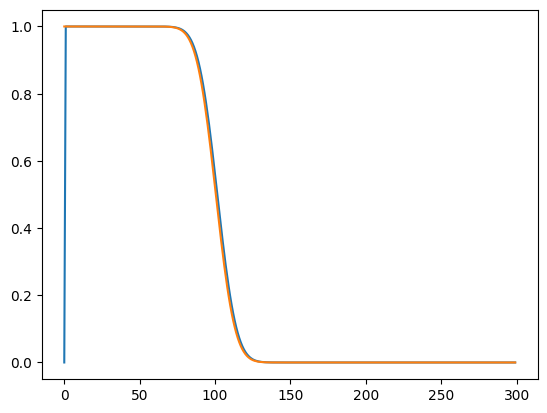

In [55]:
stimulus = np.zeros_like(stimulus)
stimulus[1] = 1
value = get_value(weights, stimulus)
plt.plot(value)
plt.plot(weights)

# Successor Learning

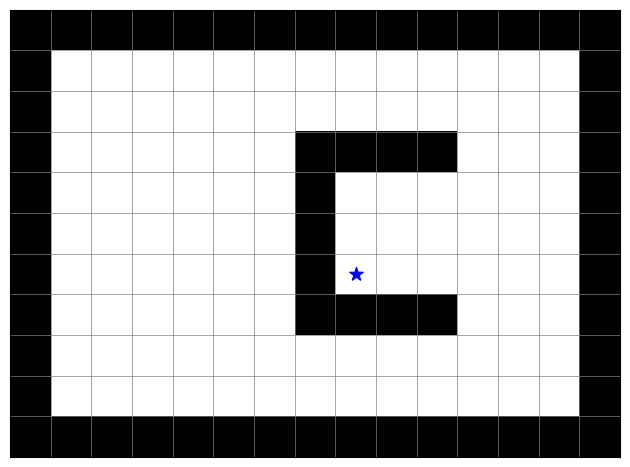

In [18]:
# define maze

maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (6, 8)

# pad maze
pad = np.ones(np.array(maze.shape) + 2)
pad[1:-1, 1:-1] = maze
maze = pad

def plot_maze(maze) -> Tuple[Figure, Axes]:
    fig, ax = plt.subplots()
    ax.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        ax.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        ax.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax

plot_maze(maze)
plt.scatter(start[1], start[0], marker='*', color='blue', s=100)
plt.tight_layout()
# plt.savefig('maze.png')
plt.show()

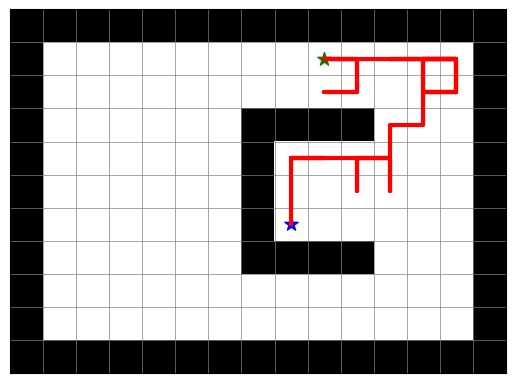

In [19]:
def random_walk(maze, start, n_steps):
    # perform a single random walk in the given maze, starting from start, performing n_steps random moves
    # moves into the wall and out of the maze boundary are not possible

    # initialize list to store positions
    
    positions = np.empty((n_steps + 1, len(maze.shape)), dtype=int)
    positions[0] = start

    # perform random steps...
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)    
    for i in range(n_steps):
        move_options = positions[i][None] + possible_moves
        # remove those moves which run into a barrier
        move_options = 1 - maze[*move_options.T]
        # int prob distribution
        p = move_options / move_options.sum()
        move_idx = np.random.choice(len(possible_moves), p=p)
        move = possible_moves[move_idx]
        positions[i+1] = positions[i] + move
        
    # return a list of length n_steps + 1, containing the starting position and all subsequent locations as e.g. tuples or size (2) arrays 
    return positions

def plot_path(maze, path):
    # plot a maze and a path in it
    plot_maze(maze)
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c='red', lw=3)
    plt.scatter(path[0, 1], path[0, 0], marker='*', color='blue', s=100)
    plt.scatter(path[-1, 1], path[-1, 0], marker='*', color='green', s=100)
    plt.show()

# plot a random path
path = random_walk(maze, start, 40)
plot_path(maze, path)

  0%|          | 0/5001 [00:00<?, ?it/s]

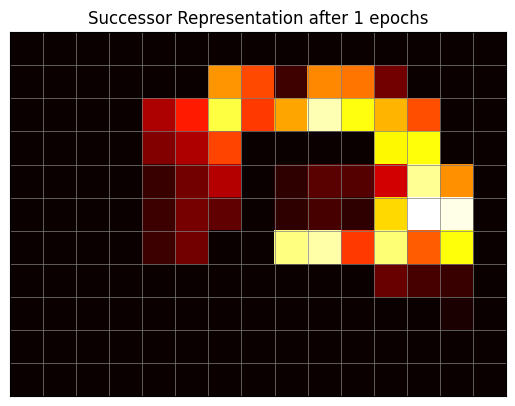

  0%|          | 1/5001 [00:00<09:13,  9.04it/s]

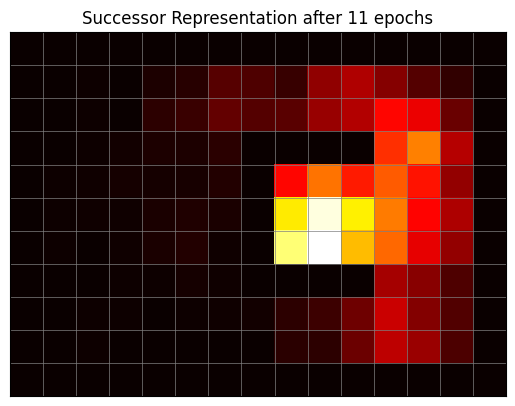

  2%|▏         | 92/5001 [00:01<00:44, 111.12it/s]

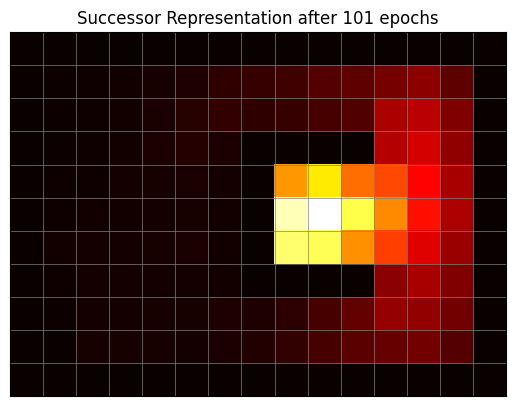

 20%|█▉        | 1000/5001 [00:08<00:31, 126.35it/s]

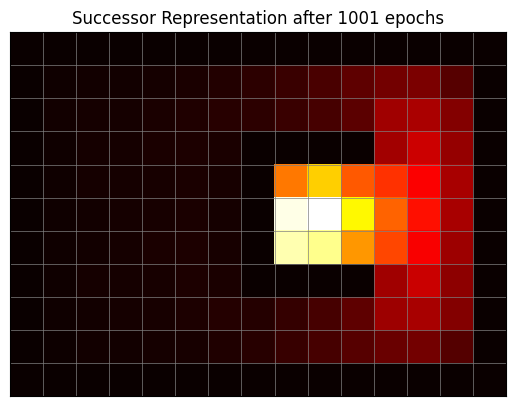

100%|█████████▉| 4998/5001 [00:40<00:00, 132.79it/s]

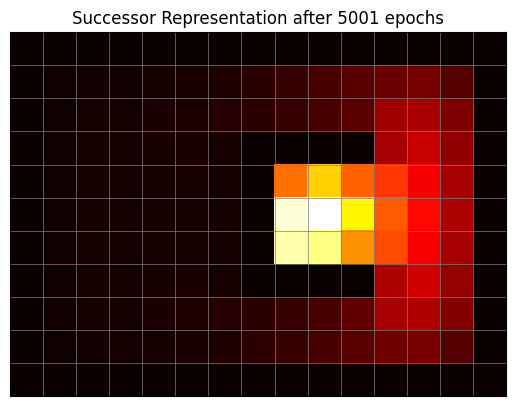

100%|██████████| 5001/5001 [00:40<00:00, 123.94it/s]


In [20]:
def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.02):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha
    
    discount = 1
    for point in trajectory:
        succ_repr[*point] += discount
        discount *= gamma

    # return the updated successor representation
    return succ_repr

# initialize successor representation
succ_repr = np.zeros_like(maze)

# sample a whole bunch of trajectories (reduce this number if this code takes too long, but it shouldn't take longer than a minute with reasonable code)
for i in tqdm(range(5001)):
    # sample a path (we use 340 steps here to sample states until the discounting becomes very small)
    path = random_walk(maze, start, 340)
    # update the successor representation
    succ_repr = learn_from_traj(succ_repr, path, alpha=0.02)  # choose a small learning rate
    
    # occasionally plot it
    if i in [0, 10, 100, 1000, 5000]:
        fig, ax = plot_maze(maze)
        ax.set_title(f"Successor Representation after {i + 1} epochs")
        # succ_repr[maze.astype(bool)] = np.nan
        ax.imshow(succ_repr, cmap='hot')
        # if i == 5000:
        #     plt.savefig("empirical")
        plt.show()
        

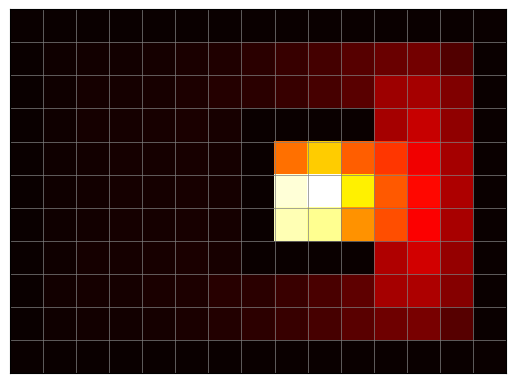

In [21]:
def compute_transition_matrix(maze: np.ndarray) -> np.ndarray:
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    n_states = len(maze.flatten())
    transitions = np.zeros((n_states, n_states))

    indices = np.arange(n_states).reshape(maze.shape)
    
    # only vertical or horizontal moves allowed
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)
    
    # allow diagonal moves
    # possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1], [1, 1], [1, -1], [-1, 1], [-1, -1]], dtype=int)

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for state_idx, (i, j) in enumerate(
        product(range(maze.shape[0]), range(maze.shape[1]))
    ):
        cell = maze[i, j]
        if cell == 1:
            continue

        coords = np.array([i, j])
        move_options = coords + possible_moves
        future_cell_values = maze[*move_options.T]
        move_options = move_options[~future_cell_values.astype(bool)]
        future_states = indices[*move_options.T]
        # print(coords, future_states)
        transitions[state_idx, future_states] += 1
        # normalize transitions if necessary
        transitions[state_idx] /= transitions[state_idx].sum()

    return transitions


transitions = compute_transition_matrix(maze)
n_states = len(transitions)

one_hot_start = np.zeros(n_states)
one_hot_start[start[0] * maze.shape[1] + start[1]] = 1

indices = np.arange(n_states).reshape(maze.shape)


succ_repr = np.zeros(n_states)
tx = np.eye(n_states)
gamma = 0.98
for i in range(340):
    succ_repr += tx.T @ one_hot_start
    tx = gamma * tx @ transitions

fig, ax = plot_maze(maze)
ax.imshow(succ_repr.reshape(maze.shape), cmap="hot")
# ax.imshow((tx.T @ one_hot_start).reshape(maze.shape), alpha=0.8, cmap="hot")

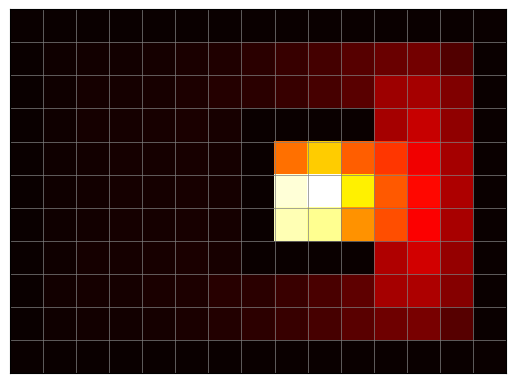

In [22]:
def compute_sr(transitions, i, j, maze, gamma=0.98):
    """
    given a transition matrix and a specific state (i, j).
    compute the successor representation of that state with discount factor gamma
    """

    # initialize things (better to represent the current discounted occupancy as a vector here)
    n_states = len(transitions)
    current_discounted_occupancy = np.zeros(n_states)
    total = current_discounted_occupancy.copy()

    one_hot_start = np.zeros(n_states)
    one_hot_start[i * maze.shape[1] + j] = 1

    # iterate for a number of steps
    tx = np.eye(n_states)
    for _ in range(340):
        current_discounted_occupancy = tx.T @ one_hot_start
        total += current_discounted_occupancy
        tx = gamma * tx @ transitions

    # return the successor representation, maybe reshape your vector into the maze shape now
    return total.reshape(maze.shape)


sr = compute_sr(transitions, *start, maze)
fig, ax = plot_maze(maze)
ax.imshow(sr, cmap="hot")
